# ARIMA-GARCH Assumption Checks

**Objective:** Verify assumptions needed for reliable ARIMA(p,d,q) modeling with a GARCH volatility component and produce diagnostic evidence for model selection.
- **Stationarity** - Checked with ADF (unit root) and KPSS (stationarity)
- **Linearity** - AR/MA are linear by design
- **No autocorrelation in residuals** - Checked with Ljung-Box test
- **Homoscedasticity** - Visual checks with residual plot
- **Invertibility**

**Workflow**:  
1. Simple feature cleaning/engineering
2. Stationarity Check 
3. PACF/ACF SARIMAX AIC BIC for p/q selection
4. Residual Diagnosis
5. Finalization of ARIMA(p/d/q)-GARCH
6. Normality Check

**Results**:
1. Log Returns for crypto (BTCUSDT) is stationary

## 1. Simple feature cleaning/engineering

In [2]:
import pandas as pd
import numpy as np

crypto = pd.read_csv("../data/raw_data/BTCUSDT_1h.csv")

# +--------------------------------------------------------------+
# |              PRELIMINARY FEATURE ENGINEERING                 |
# +--------------------------------------------------------------+

# checking if timestamp has any gaps/duplicates
crypto['timestamp'] = pd.to_datetime(crypto['timestamp'])
crypto = crypto.sort_values(by='timestamp').reset_index(drop=True)
crypto = crypto.drop_duplicates(subset=['timestamp']).reset_index(drop=True)

# log returns
crypto['log_return'] = np.log(crypto['close'] / crypto['close'].shift(1))
crypto = crypto.dropna(subset=['log_return']).reset_index(drop=True)

display(crypto)

,timestamp,open,high,low,close,volume,log_return
0,2020-01-01 01:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,0.005454
1,2020-01-01 02:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,0.003677
2,2020-01-01 03:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,-0.002466
3,2020-01-01 04:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,-0.001072
4,2020-01-01 05:00:00,7217.26,7229.76,7216.65,7224.21,344.670596,0.000961
...,...,...,...,...,...,...,...
43810,2024-12-31 19:00:00,93875.69,94290.91,93712.45,94166.88,462.793420,0.003097
43811,2024-12-31 20:00:00,94166.88,94222.50,93450.17,93564.04,733.041470,-0.006422
43812,2024-12-31 21:00:00,93564.01,93964.15,93504.67,93899.68,337.527150,0.003581
43813,2024-12-31 22:00:00,93899.67,93899.67,93375.58,93488.84,315.532720,-0.004385


## 2. Stationarity Check

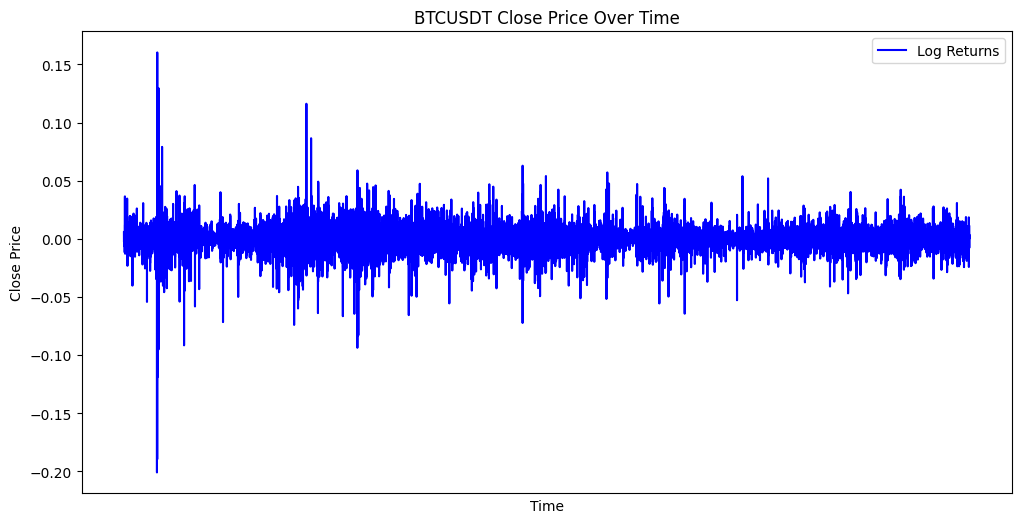

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(crypto['timestamp'], crypto['log_return'], label='Log Returns', color='blue')
plt.title('BTCUSDT Close Price Over Time')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")

# +--------------------------------------------------------------+
# |                   ADF TEST OF STATIONARITY                   |
# +--------------------------------------------------------------+
print("🔍 Augmented Dickey-Fuller Test:")
print("H0: The series has a unit root (non-stationary)")
print("H1: The series is stationary")
print("-" * 50)

adf_result = adfuller(crypto['log_return'])     # * Actual test is done here XDD
print("ADF Statistic:", adf_result[0])

if adf_result[1] < 0.05:
    print(f"✅ The series is stationary with p-value {adf_result[1]} (reject H0)\n")
else:
    print(f"❌ The series is non-stationary with p-value {adf_result[1]} (fail to reject H0)\n")


# +--------------------------------------------------------------+
# |                 KPSS TEST OF STATIONARITY                    |
# +--------------------------------------------------------------+
print("=" * 50 ,"\n🔍 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print("H0: The series is stationary")  
print("H1: The series has a unit root (non-stationary)")
print("-" * 50)

kpss_result = kpss(crypto['log_return'], regression='c', nlags="auto")  # * Actual test is done here XDD
print("KPSS Statistic:", kpss_result[0])  

if kpss_result[1] < 0.05:
    print(f"❌ The series is non-stationary with p-value {kpss_result[1]} (reject H0)")  
else:
    print(f"✅ The series is stationary with p-value {kpss_result[1]} (fail to reject H0)")

🔍 Augmented Dickey-Fuller Test:
H0: The series has a unit root (non-stationary)
H1: The series is stationary
--------------------------------------------------
ADF Statistic: -29.090831548018254
--------------------------------------------------
✅ The series is stationary with p-value 0.0 (reject H0)

🔍 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
H0: The series is stationary
H1: The series has a unit root (non-stationary)
--------------------------------------------------
KPSS Statistic: 0.17799457914727884
--------------------------------------------------
✅ The series is stationary with p-value 0.1 (fail to reject H0)


## PACF/ACF diagnosis for p/q selection 

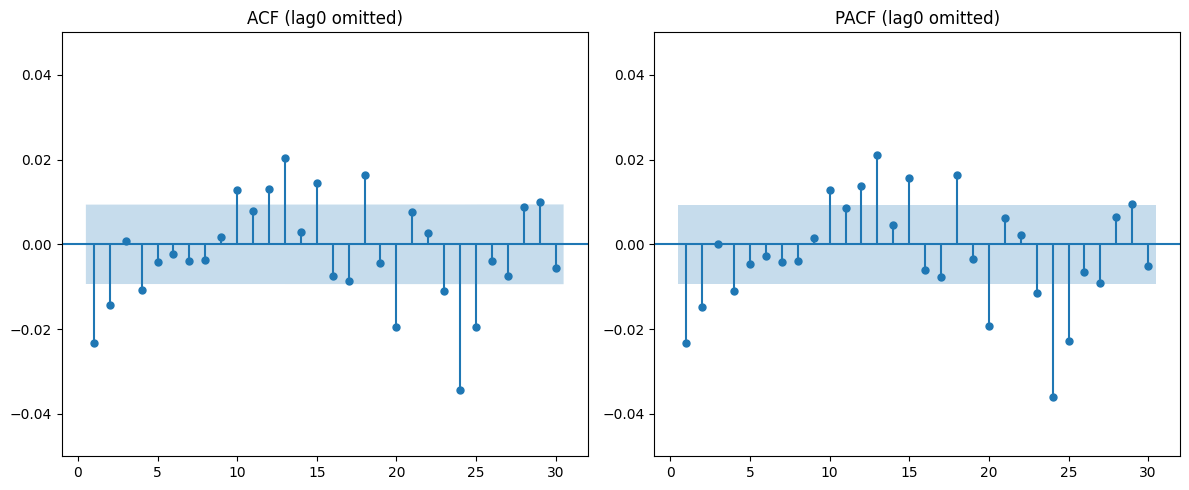

N=43815, 95% conf bound ≈ ±0.00936

Significant ACF lags (>|conf|): [1, 2, 4, 10, 12, 13, 15, 18, 20, 23, 24, 25, 29]
Significant PACF lags (>|conf|): [1, 2, 4, 10, 12, 13, 15, 18, 20, 23, 24, 25, 29]

Ljung-Box test (lags 5,10,20):
       lb_stat     lb_pvalue
5    38.363744  3.188735e-07
10   47.182020  8.749403e-07
20  119.990185  2.863467e-16

Ljung-Box (residual whiteness) for the series (lags 5,10,20):
       lb_stat     lb_pvalue
5    38.363744  3.188735e-07
10   47.182020  8.749403e-07
20  119.990185  2.863467e-16


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# +--------------------------------------------------------------+
# |            ACF AND PACF PLOTS (p/q selection)                |
# +--------------------------------------------------------------+
y = crypto['log_return'].dropna()
n = len(y)
nlags = 30

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_acf(y, lags=nlags, ax=plt.gca(), zero=False)
plt.ylim(-0.05, 0.05)
plt.title('ACF (lag0 omitted)')

plt.subplot(1,2,2)
plot_pacf(y, lags=nlags, ax=plt.gca(), zero=False, method='ywm')
plt.ylim(-0.05, 0.05)
plt.title('PACF (lag0 omitted)')

plt.tight_layout()
plt.show()

acf_vals = acf(y.values, nlags=nlags, fft=True)         # finds acf values up to lag=nlags
pacf_vals = pacf(y.values, nlags=nlags, method='ywm')   # finds pacf values up to lag=nlags

conf = 1.96 / np.sqrt(n)                                # this uses a normal approximation that corr~N(0,1/n)
print(f"N={n}, 95% conf bound ≈ ±{conf:.5f}\n")

# significant lags where |corr| > conf
sign_acf = [k for k, v in enumerate(acf_vals) if k>0 and abs(v) > conf]
sign_pacf = [k for k, v in enumerate(pacf_vals) if k>0 and abs(v) > conf]

print("Significant ACF lags (>|conf|):", sign_acf or "None")
print("Significant PACF lags (>|conf|):", sign_pacf or "None")


# +--------------------------------------------------------------+
# |                     LJUNG BBOX AC TEST                       |
# +--------------------------------------------------------------+
print("\nLjung-Box test (lags 5,10,20):")
print(acorr_ljungbox(y.values, lags=[5,10,20], return_df=True))


print("\nLjung-Box (residual whiteness) for the series (lags 5,10,20):")
print(acorr_ljungbox(y.values, lags=[5,10,20], return_df=True))


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

y = crypto['log_return'].dropna()
d = 0           # log returns are normally stationary, so d=0
p_max, q_max = 3, 3

rows = []
for p in range(p_max+1):
    for q in range(q_max+1):
        try:
            m = SARIMAX(y, order=(p, d, q), trend='n').fit(disp=False, maxiter=200)
            lb10 = acorr_ljungbox(m.resid, lags=[10], return_df=True).iloc[0]['lb_pvalue']
            lb20 = acorr_ljungbox(m.resid, lags=[20], return_df=True).iloc[0]['lb_pvalue']
            arch_p = het_arch(m.resid, nlags=12)[1]                                             # p-value of ARCH LM
            rows.append({'p':p, 'd':d, 'q':q, 'aic':m.aic, 'bic':m.bic,
                         'lb10_resid_p': lb10, 'lb20_resid_p': lb20, 'arch_p': arch_p})
        except Exception as e:
            # skip models that fail to converge
            continue

res_df = pd.DataFrame(rows).sort_values(['aic','bic']).reset_index(drop=True)
print("Top candidate models by AIC:\n", res_df.head(10))

if not res_df.empty:
    best = res_df.iloc[0]
    print("\nBest candidate => p,d,q:", int(best.p), int(best.d), int(best.q))
    print("Note: residual Ljung-Box p-values should be > 0.05 (no remaining serial corr).")
    print("ARCH p-value > 0.05 means no strong ARCH left in residuals (if you'll use GARCH later).")

Top candidate models by AIC:
    p  d  q            aic            bic  lb10_resid_p  lb20_resid_p  arch_p
0  1  0  1 -309961.974307 -309935.911112      0.120454  6.336221e-11     0.0
1  0  0  2 -309961.700041 -309935.636846      0.110090  7.075579e-11     0.0
2  2  0  0 -309961.507229 -309935.444034      0.104627  6.888946e-11     0.0
3  2  0  2 -309959.843811 -309916.405154      0.197482  1.295046e-10     0.0
4  1  0  2 -309959.719187 -309924.968261      0.110053  6.562452e-11     0.0
5  0  0  3 -309959.698869 -309924.947943      0.110293  7.282150e-11     0.0
6  2  0  1 -309959.510898 -309924.759972      0.104848  6.980061e-11     0.0
7  3  0  0 -309959.508703 -309924.757777      0.104782  6.974336e-11     0.0
8  3  0  1 -309957.506595 -309914.067938      0.104718  6.968820e-11     0.0
9  1  0  3 -309957.466727 -309914.028070      0.103051  6.636594e-11     0.0

Best candidate => p,d,q: 1 0 1
Note: residual Ljung-Box p-values should be > 0.05 (no remaining serial corr).
ARCH p-value